## Exploring the power outage time-series dataset (eaglei_outages_2016.csv)

The `eaglei_outages_2016.csv` file is structured a little differently. Each row represents 15 minute increments in the year 2016 for a county, and gives the number of customers who were out of power during that 15 minute period in the "sum" column. In this datset, you get data that evolves over a period of time (in this case, over the year 2016). As you can imagine, with the number of 15 minute increments in a year and the number of counties in the US, there are a lot of rows. This is called a 'time series' dataset.

Two things to note about the data in run_start_time and sum:
1. The time is given in UTC so it is not showing the timezone of the county in question.
2. Not all time intervals between data points are in intervals of 15 min. If there were no power outages happening in a county during a particular 15 min interval, those rows are left out of the data table. This helps minimize the size of the data set. However, it may make it more difficult to compare counties with different time sample rates.

Let's create a dataframe with this dataset. Make sure the 'eaglei_outages_2016.csv' file is in the data folder.

In [1]:
import numpy as np
import scipy
from scipy import interpolate
import pandas as pd

In [2]:
# Load up Eagle-I 2016 Dataset
eaglei_outages_df = pd.read_csv("data/eaglei_outages_2016.csv", delimiter=',', skiprows=0, low_memory=False)

In [3]:
eaglei_outages_df

,fips_code,county,state,sum,run_start_time
0,2122,Kenai Peninsula,Alaska,657,2016-01-01 00:00:00
1,5003,Ashley,Arkansas,7,2016-01-01 00:00:00
2,5029,Conway,Arkansas,2,2016-01-01 00:00:00
3,5069,Jefferson,Arkansas,41,2016-01-01 00:00:00
4,5081,Little River,Arkansas,61,2016-01-01 00:00:00
...,...,...,...,...,...
13306019,54061,Monongalia,West Virginia,472,2016-12-31 00:00:00
13306020,54069,Ohio,West Virginia,37,2016-12-31 00:00:00
13306021,54075,Pocahontas,West Virginia,200,2016-12-31 00:00:00
13306022,54099,Wayne,West Virginia,2,2016-12-31 00:00:00


You can see that there is a column called 'run_start_time' that marks a date and time. That will allow you to filter for specific days, or even specific date or time ranges. For example, if you want to filter the rows down to only those for 2016-01-20 and 2016-06-21, you can do so by doing something like

In [4]:
# we can combine two or more conditions in loc with the & symbol
# the & symbol between conditions indicates that both need to be satisfied for a given row
eaglei_outages_20_21_df = eaglei_outages_df.loc[(eaglei_outages_df['run_start_time'] >= "2016-06-20 00:00:00") 
                                                & (eaglei_outages_df['run_start_time'] < "2016-06-22 00:00:00")]
eaglei_outages_20_21_df

,fips_code,county,state,sum,run_start_time
5966141,4013,Maricopa,Arizona,754,2016-06-20 00:00:00
5966142,4019,Pima,Arizona,1027,2016-06-20 00:00:00
5966143,5003,Ashley,Arkansas,54,2016-06-20 00:00:00
5966144,5045,Faulkner,Arkansas,2,2016-06-20 00:00:00
5966145,5093,Mississippi,Arkansas,2,2016-06-20 00:00:00
...,...,...,...,...,...
6046879,55073,Marathon,Wisconsin,1,2016-06-21 23:45:00
6046880,55093,Pierce,Wisconsin,1,2016-06-21 23:45:00
6046881,55101,Racine,Wisconsin,2,2016-06-21 23:45:00
6046882,55133,Waukesha,Wisconsin,7,2016-06-21 23:45:00


Now, from this, say we want to compare the power outage numbers over those two days for certain counties (e.g. Los Angeles,CA and Pima,AZ) with a line chart, how do we do that? 

We could just make separate line charts. That's pretty easy.


In [5]:
losangeles_df = eaglei_outages_20_21_df.loc[eaglei_outages_df['fips_code'] == 6037]
losangeles_df.plot(x="run_start_time", y="sum", rot=90, title="Los Angeles Power outages", ylabel="power outages", label="LA power outages")

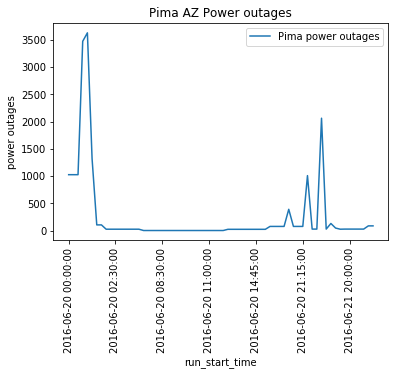

In [6]:
pima_df = eaglei_outages_20_21_df.loc[eaglei_outages_df['fips_code'] == 4019]
pima_df.plot(x="run_start_time", y="sum", rot=90, title="Pima AZ Power outages", ylabel="power outages", label="Pima power outages")

But it would be neat if they could be on the same chart. How do we do that? We can do something like the below

Text(0.5, 1.0, 'Comparing LA and Pima')

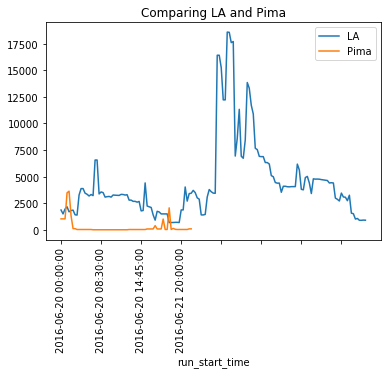

In [7]:
from matplotlib import pyplot as plt
fig, ax = plt.subplots()
# specifying ax makes sure that the same figure is used for plotting both dataframes
# los angeles data
losangeles_df.plot(ax=ax,x="run_start_time", y="sum", rot=90, label="LA")
# Pima data
pima_df.plot(ax=ax,x="run_start_time", y="sum", rot=90, label="Pima")
plt.title("Comparing LA and Pima")



Well that looks a little weird, doesn't it? What happened? 

Let's investigate the size of the Los Angeles and Pima dataframes

In [8]:
print("rows, columns of the LA dataframe:", losangeles_df.shape)
print("rows, columns of the Pima dataframe:", pima_df.shape)

rows, columns of the LA dataframe: (153, 5)
rows, columns of the Pima dataframe: (66, 5)


As you can see, the LA dataframe has a lot more rows than the Pima dataframe. This could indicate that the Pima dataframe does not have all the timestamps that the LA dataframe has i.e. there is more data collected for the LA dataframe. So we're running into the age old problem in data science: missing data. Always be wary of the fact that your data may not be as complete as you think! We can still do the comparison though, we just need to up sample the time series data for Pima and interpolate the power outage data to match the new sample rate. We will start by converting the date and time data into an integer so that it is easier to up sample. Here is an explanation  of linear interpolation: https://en.wikipedia.org/wiki/Linear_interpolation.

In [9]:
# use the to_datetime function and the apply function to covert the date and  
# into a single representative integer called “time”. 
pima_df['time'] = pima_df['run_start_time'].apply(lambda run_start_time : pd.to_datetime(run_start_time).value)

pima_df

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,fips_code,county,state,sum,run_start_time,time
5966142,4019,Pima,Arizona,1027,2016-06-20 00:00:00,1466380800000000000
5966603,4019,Pima,Arizona,1027,2016-06-20 00:15:00,1466381700000000000
5967039,4019,Pima,Arizona,1027,2016-06-20 00:30:00,1466382600000000000
5967478,4019,Pima,Arizona,3474,2016-06-20 00:45:00,1466383500000000000
5967928,4019,Pima,Arizona,3629,2016-06-20 01:00:00,1466384400000000000
...,...,...,...,...,...,...
6038024,4019,Pima,Arizona,29,2016-06-21 20:15:00,1466540100000000000
6038644,4019,Pima,Arizona,29,2016-06-21 20:30:00,1466541000000000000
6039252,4019,Pima,Arizona,29,2016-06-21 20:45:00,1466541900000000000
6045194,4019,Pima,Arizona,88,2016-06-21 23:15:00,1466550900000000000


In [10]:
pd.to_datetime(1466380800000000000)

Timestamp('2016-06-20 00:00:00')

In [11]:
losangeles_df['time'] = losangeles_df['run_start_time'].apply(lambda run_start_time : pd.to_datetime(run_start_time).value)

losangeles_df

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,fips_code,county,state,sum,run_start_time,time
5966152,6037,Los Angeles,California,1858,2016-06-20 00:00:00,1466380800000000000
5966613,6037,Los Angeles,California,1495,2016-06-20 00:15:00,1466381700000000000
5967049,6037,Los Angeles,California,1949,2016-06-20 00:30:00,1466382600000000000
5967489,6037,Los Angeles,California,2165,2016-06-20 00:45:00,1466383500000000000
5967939,6037,Los Angeles,California,1692,2016-06-20 01:00:00,1466384400000000000
...,...,...,...,...,...,...
6044061,6037,Los Angeles,California,1067,2016-06-21 22:45:00,1466549100000000000
6044634,6037,Los Angeles,California,892,2016-06-21 23:00:00,1466550000000000000
6045205,6037,Los Angeles,California,892,2016-06-21 23:15:00,1466550900000000000
6045775,6037,Los Angeles,California,912,2016-06-21 23:30:00,1466551800000000000


### How to Up Sample Data with numpy

To make a comparison, both the Los Angeles and Pima county data sets need to be up-sampled so that they have the same time frequency. We'll create a time array, new_t, that has the same time frequency of 15 minute intervals and then interpolate between all the data points in the each data series to follow the new complete 15 minute time frequency in new_t. 

We will use numpy arrays to do the interpolation because numpy has an interpolate function that will make this quite easy. It may be possible to do it entirely in pandas data frames, though. Perhaps you can google it and find out!



In [12]:
#Step 1: Convert all the pandas dataframes for time and sum of outages to numpy arrays. 
#tla_arr is the timestamp array for Los Angeles County
#sla_arr is the sum of customers without power for that timestamp for Los Angeles County
#tp_arr is the timestamp array for Pima County
#sla_arr is the sum of customers without power for that timestamp for Pima County
import numpy as np
tla_arr = losangeles_df['time'].to_numpy()
sla_arr = losangeles_df['sum'].to_numpy()
tp_arr = pima_df['time'].to_numpy()
sp_arr= pima_df['sum'].to_numpy()


In [13]:
# Step 2: make a group of functions that follow the changes in time and number of outage between each data point in each series. 
# For example, if the time interval between the first and second data points in the Pima county data series is 30 minutes rather
# than 15 min, like it is in the LA County series, these functions below
# help us follow that so we will be able to up sample the Pima series for 15 minute intervals.


fp = interpolate.interp1d(tp_arr,tp_arr)
ffp = interpolate.interp1d(tp_arr,sp_arr)
fs = interpolate.interp1d(tla_arr,tla_arr)
ffs= interpolate.interp1d(tla_arr,sla_arr)

Step 3: Make a time series array to use to up sample all the data to the time frequency we want. 

We will use the numpy np.arrange function to do this. It takes three arguments: start time, end time and increment. In the cells below, we find those values using the Los Angeles data because it has the highest sample rate. 



In [14]:
#Step 3a: Find the time increment

#We want a time frequency that captures the best available detail in the data. 

#If you go up and look at the run_start_time data for LA country, you will notice that most data points are 15 minutes apart. 
# a 15 minute increment corresponds to 900000000000 in our timestamp. 

#Find the time increment in the LA data by subtracting the first time from the second timestamp data.
test = 1466382600000000000 - 1466381700000000000
test


900000000000

In [15]:
#Step 3b: Find how large our sampling array should be. 
# find the last value in the array 
print(losangeles_df.iloc[-1])

fips_code                        6037
county                    Los Angeles
state                      California
sum                               901
run_start_time    2016-06-21 23:45:00
time              1466552700000000000
Name: 6046333, dtype: object


In [16]:
# Step 3c: Make an array that has a timestamp for every 15 minutes for the full range of the time data in the day.  
# # np.arange(start time, end time, increment) 
# we cut and past the start time from the first point in the Los Angeles data series. 
# we use the end time and increment that we found in the cells above.

new_t=np.arange(1466380800000000000,1466552700000000000,900000000000)
len(new_t)

191

Note from the len function above that this array has 191 elements, so even the Los Angeles county data (161 elements) will need to be up sampled.

In [17]:
# Step 4: use the functions you found in step 2 above and the new_t array from Step 3, t
# to up sample all of the time and sum ( of customers without power) data 
# to the new time frequency of 15 minutes.  

# xnewp = Pima timestamp upsampled to 15 min intervals
# xnewpt = Upsample Pima timestamp data converted back to human readable Month/Day/Hour 
# ynewp Pima "sum" data up sampled to the new 15 min time intervals 
# xnewla = Los Angeles timestamp upsampled to 15 min intervals
# ynewla = Los Angeles "sum" upsampled to 15 min intervals

xnewp = fp(new_t)
xnewpt=pd.to_datetime(new_t)
ynewp = ffp(new_t)
xnewla = fs(new_t)
ynewla = ffs(new_t)


/opt/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/opt/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/opt/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/opt/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will

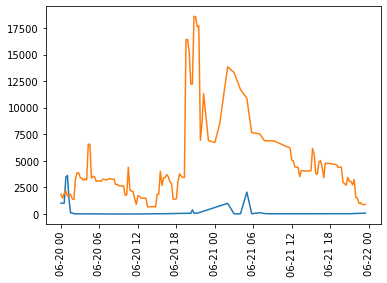

In [18]:
# Plot the data 

plt.xticks(rotation=90);
plt.plot(xnewpt,ynewp,'-')
plt.plot(xnewpt,ynewla,'-')


Interesting!

Los Angeles County CA has a much larger total number of customers without power than Pima county AZ. Both counties seem to be having a significant power outage near 6:00 am UTC. What time is it in each of those counties at 6:00 am UTC? 


### Exercise

1. Pick another nearby county or a few, up sample and interpolate their data and then plot them with Pima and Los Angeles (San Bernadino CA would be interesting). 

2. Do their outage maximums happen near the same times?

3. What do you suppose accounts most for the very different number of customers without power for each county? What might you test to tackle that question? 

Next up: Let’s learn how to visualize things like population, number of customers, and poverty to see how those compare for your selected counties. 

### 6. Aggregating time series data to get mean and median

Now that we've learned how to work with and visualize time series, it would also be useful to know how to aggregate data across a time series. Say you want to find the average of power outages across the whole day for Los Angeles county for June 20. But we know that the data is in 15 minute chunks, and that the run_start_time column is in UTC so has to be adjusted to get June 20 local time.

Again, Pandas comes to the rescue. Let's make use of the eaglei_outages_df we created earlier

In [19]:
eaglei_outages_df

,fips_code,county,state,sum,run_start_time
0,2122,Kenai Peninsula,Alaska,657,2016-01-01 00:00:00
1,5003,Ashley,Arkansas,7,2016-01-01 00:00:00
2,5029,Conway,Arkansas,2,2016-01-01 00:00:00
3,5069,Jefferson,Arkansas,41,2016-01-01 00:00:00
4,5081,Little River,Arkansas,61,2016-01-01 00:00:00
...,...,...,...,...,...
13306019,54061,Monongalia,West Virginia,472,2016-12-31 00:00:00
13306020,54069,Ohio,West Virginia,37,2016-12-31 00:00:00
13306021,54075,Pocahontas,West Virginia,200,2016-12-31 00:00:00
13306022,54099,Wayne,West Virginia,2,2016-12-31 00:00:00


In [20]:
# to get only Los Angeles, let's select by the FIPS code and also make sure that run_start_time is
# within 2016-06-20 00:00:00 and 2016-06-21 00:00:00 Pacific Standard Time (or in the case of June
# Pacific Daylight Time, which is 7 hours behind UTC)
la_outages_0620_df = eaglei_outages_df.loc[(eaglei_outages_df["fips_code"]==6037) 
                                          & (eaglei_outages_df["run_start_time"]>="2016-06-19 17:00:00")
                                          & (eaglei_outages_df["run_start_time"]<="2016-06-20 17:00:00")]
la_outages_0620_df


,fips_code,county,state,sum,run_start_time
5953439,6037,Los Angeles,California,167,2016-06-19 17:00:00
5953892,6037,Los Angeles,California,144,2016-06-19 17:15:00
5954341,6037,Los Angeles,California,152,2016-06-19 17:30:00
5954792,6037,Los Angeles,California,153,2016-06-19 17:45:00
5955241,6037,Los Angeles,California,162,2016-06-19 18:00:00
...,...,...,...,...,...
5993451,6037,Los Angeles,California,3404,2016-06-20 16:00:00
5994131,6037,Los Angeles,California,3433,2016-06-20 16:15:00
5994808,6037,Los Angeles,California,3706,2016-06-20 16:30:00
5995490,6037,Los Angeles,California,3498,2016-06-20 16:45:00


We then need to use the groupby method to group the la_outages_0620_df by the fips code. This is necessary since pandas needs to group the data first before it can do any aggregation operations.

In [21]:

la_outages_grouped=la_outages_0620_df.groupby("fips_code")
la_outages_grouped

In [22]:
# now we can aggregate the data in each group (i.e. in each county) 
# to get the mean and median of the customers with out power per day. 

la_outages_agg = la_outages_grouped[["county", "state", "sum"]].agg({"county":"first", "state":"first", "sum":["mean", "median"] })
la_outages_agg

county       state          sum        
                 first       first         mean  median
fips_code                                              
6037       Los Angeles  California  2037.154639  1815.0

Now groupby and agg isn't as useful if all you want is the aggregate data for one 'group' (in this case, the group is all data with fips_code==6037) since you could just find the average of the 'sum' column with other python functions after you filter down to LA county data. However, if you have multiple 'groups', like for example

In [23]:
# Note: For the most part, CA, AZ, and NV operate in UTC-7 (MST or PDT). Individual counties you may look at might
# differ so make sure to adjust time range if you feel it necessary
swus_outages_0620_df = eaglei_outages_df.loc[(eaglei_outages_df["run_start_time"]>="2016-06-19 17:00:00")
                                          & (eaglei_outages_df["run_start_time"]<="2016-06-20 17:00:00")]
swus_outages_0620_df

,fips_code,county,state,sum,run_start_time
5953428,1041,Crenshaw,Alabama,2,2016-06-19 17:00:00
5953429,1089,Madison,Alabama,24,2016-06-19 17:00:00
5953430,1109,Pike,Alabama,2,2016-06-19 17:00:00
5953431,4013,Maricopa,Arizona,486,2016-06-19 17:00:00
5953432,5009,Boone,Arkansas,1,2016-06-19 17:00:00
...,...,...,...,...,...
5996808,55101,Racine,Wisconsin,1,2016-06-20 17:00:00
5996809,55111,Sauk,Wisconsin,16,2016-06-20 17:00:00
5996810,55125,Vilas,Wisconsin,68,2016-06-20 17:00:00
5996811,55133,Waukesha,Wisconsin,43,2016-06-20 17:00:00


In [24]:
# Now grouping and aggregating them

swus_outages_grouped = swus_outages_0620_df.groupby("fips_code")
swus_outages_agg = swus_outages_grouped[["county", "state", "sum"]].agg({"county":"first", "state":"first", "sum":["mean", "median"] })
swus_outages_agg

county      state         sum       
               first      first        mean median
fips_code                                         
1003         Baldwin    Alabama    3.666667    1.0
1013          Butler    Alabama    2.714286    3.0
1031          Coffee    Alabama   21.363636   26.0
1039       Covington    Alabama    1.000000    1.0
1041        Crenshaw    Alabama  168.600000  169.5
...              ...        ...         ...    ...
55133       Waukesha  Wisconsin    9.358209    2.0
55135        Waupaca  Wisconsin    4.428571    5.0
55139      Winnebago  Wisconsin    1.000000    1.0
55141           Wood  Wisconsin    1.000000    1.0
56021        Laramie    Wyoming   89.000000   89.0

[1494 rows x 4 columns]

A few things to consider:

1. Many of these counties have very different populations so the mean number of outages per time calculated for a county with a small number of customers may represent a larger fraction of county’s population being without power than a similar mean for a county with a large population though each of those similar sized means represent a similar number of customers without power. 
In order to get a baseline, you could measure a given county's average power outage against the total number of power customers in that county.

2. If you use this to get the mean number of outages for all counties in the US, note that Eagle-I in 2016 did not have data for all U.S. counties. 

Since the Eagle-I data spans across from 2014 to 2022, another way to analyze the sum of power outages across the years is to process these datasets in parallel by using MPI techniques.

Leveraging MPI distributes the computational workload across multiple processors or nodes, which potentially allows for faster and more efficient analysis of large datasets.

See: 